In [ ]:
# 카테고리별로 따로 회귀분석을 하여 정확도가 높아지는지 비교.

유튜브에서 공개한 주요 요인들을 보면,

View count  (many)

The rate of growth in views (급격하게)

Where views are coming from (including outside of YouTube)-(다양한 장소에서)

The age of the video (최신)

들이 있는데 최근에 급격하게 비디오 뷰가 상승하는 것이 트렌드 비디오가 되는 강력한 요인이 될것으로 가정할수 있다. 분석을 통해 이 가정이 옳은지 확인해보자.

In [1]:
# Import our libraries we are going to use for our data analysis.
#import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [2]:

df = pd.read_csv('./US(subscriber).csv')
df_origin=df.copy()

us_videos_categories = pd.read_json('./US_category_id.json')
# Map Category IDs using the supporting file: US_category_id.json
categories = {int(category['id']): category['snippet']['title'] for category in us_videos_categories['items']}

In [3]:
counter = 0
for k,v in categories.items():
    print('{:2d}: {:24}'.format(k,v),end=' ')
    counter += 1
    if counter % 4 == 0:
        print()
print('\n{} Categories in Total.'.format(counter))

 1: Film & Animation          2: Autos & Vehicles         10: Music                    15: Pets & Animals           
17: Sports                   18: Short Movies             19: Travel & Events          20: Gaming                   
21: Videoblogging            22: People & Blogs           23: Comedy                   24: Entertainment            
25: News & Politics          26: Howto & Style            27: Education                28: Science & Technology     
29: Nonprofits & Activism    30: Movies                   31: Anime/Animation          32: Action/Adventure         
33: Classics                 34: Comedy                   35: Documentary              36: Drama                    
37: Family                   38: Foreign                  39: Horror                   40: Sci-Fi/Fantasy           
41: Thriller                 42: Shorts                   43: Shows                    44: Trailers                 

32 Categories in Total.


## Date modeling for Regression 

In [4]:
df.columns

Index(['channel_title', 'n', 'video_id', 'trending_date', 'title',
       'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes',
       'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'video_error_or_removed', 'description',
       'channel_id', 'subscribe', 'topic', 'len_title', 'nword_title',
       'n_tags'],
      dtype='object')

In [5]:
df['category'] = [categories[cid] for cid in df.category_id]
df.drop('category_id',axis=1,inplace=True)
df.drop('topic',axis=1,inplace=True)
df

,channel_title,n,video_id,trending_date,title,publish_time,tags,views,likes,dislikes,...,comments_disabled,ratings_disabled,video_error_or_removed,description,channel_id,subscribe,len_title,nword_title,n_tags,category
0,CaseyNeistat,95,2kyS6SvSYSE,11/14/2017,WE WANT TO TALK ABOUT OUR MARRIAGE,11/13/2017 17:13,SHANtell martin,748374,57527,2966,...,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,UCtinbF-Q-fVthA0qrFQTgXQ,10460409,34,7,1,People & Blogs
1,LastWeekTonight,24,1ZAPwfrtAFY,11/14/2017,The Trump Presidency: Last Week Tonight with J...,11/13/2017 7:30,"last week tonight trump presidency""|""last week...",2418783,97185,6146,...,False,False,False,"One year after the presidential election, John...",UC3XTzVzaHQEd30rQbuvCtTQ,6505413,62,10,4,Entertainment
2,Rudy Mancuso,74,5qpjK5DgCt4,11/14/2017,"Racist Superman | Rudy Mancuso, King Bach & Le...",11/12/2017 19:05,"racist superman""|""rudy""|""mancuso""|""king""|""bach...",3191434,146033,5339,...,False,False,False,WATCH MY PREVIOUS VIDEO <U+25B6> \n\nSUBSCRIBE...,UC5jkXpfnBhlDjqh0ir5FsIQ,5487024,53,8,22,Comedy
3,Good Mythical Morning,147,puqaWrEC7tY,11/14/2017,Nickelback Lyrics: Real or Fake?,11/13/2017 11:00,"rhett and link""|""gmm""|""good mythical morning""|...",343168,10172,666,...,False,False,False,Today we find out if Link is a Nickelback amat...,UC4PooiX37Pld1T8J5SYT-SQ,14395362,32,5,27,Entertainment
4,nigahiga,89,d380meD0W0M,11/14/2017,I Dare You: GOING BALD!?,11/12/2017 18:01,"ryan""|""higa""|""higatv""|""nigahiga""|""i dare you""|...",2095731,132235,1989,...,False,False,False,I know it's been a while since we did this sho...,UCSAUGyc_xA8uYzaIVG6MESQ,21284569,24,5,14,Entertainment
5,iJustine,99,gHZ1Qz0KiKM,11/14/2017,2 Weeks with iPhone X,11/13/2017 19:07,"ijustine""|""week with iPhone X""|""iphone x""|""app...",119180,9763,511,...,False,False,False,Using the iPhone for the past two weeks -- her...,UCey_c7U86mJGz1VJWH5CYPA,5364143,21,5,7,Science & Technology
6,Saturday Night Live,175,39idVpFF7NQ,11/14/2017,Roy Moore & Jeff Sessions Cold Open - SNL,11/12/2017 5:37,"SNL""|""Saturday Night Live""|""SNL Season 43""|""Ep...",2103417,15993,2445,...,False,False,False,Embattled Alabama Senate candidate Roy Moore (...,UCqFzWxSCi39LnW1JKFR3efg,6752951,41,7,42,Entertainment
7,CrazyRussianHacker,115,nc99ccSXST0,11/14/2017,5 Ice Cream Gadgets put to the Test,11/12/2017 21:50,"5 Ice Cream Gadgets""|""Ice Cream""|""Cream Sandwi...",817732,23663,778,...,False,False,False,Ice Cream Pint Combination Lock - http://amzn....,UCe_vXdMrHHseZ_esYUskSBw,10884231,35,8,13,Science & Technology
8,20th Century Fox,135,jr9QtXwC9vc,11/14/2017,The Greatest Showman | Official Trailer 2 [HD]...,11/13/2017 14:00,"Trailer""|""Hugh Jackman""|""Michelle Williams""|""Z...",826059,3543,119,...,False,False,False,"Inspired by the imagination of P.T. Barnum, Th...",UC2-BeLxzUBSs0uSrmzWhJuQ,3216812,65,10,28,Film & Animation
9,Vox,193,TUmyygCMMGA,11/14/2017,Why the rise of the robots won?t mean the end ...,11/13/2017 13:45,"vox.com""|""vox""|""explain""|""shift change""|""futur...",256426,12654,1363,...,False,False,False,"For now, at least, we have better things to wo...",UCLXo7UDZvByw2ixzpQCufnA,4915727,53,13,20,News & Politics


In [6]:
# Transform trending_date to datetime date format

df['trending_date'] = pd.to_datetime(df['trending_date'], format='%m/%d/%Y').dt.date
df.trending_date.value_counts().sort_index(inplace=True)

In [7]:
# Transforming publish_time to datetime
publish_time = pd.to_datetime(df.publish_time, format='%m/%d/%Y %H:%M')
# Create Variable publish_date
df['publish_date'] = publish_time.dt.date

In [8]:
# Drop publish_time
df.drop('publish_time',axis=1,inplace=True)

In [9]:
# Create New Variable Counting Days to Achieving Trending Status
df['days_to_trending'] = (df.trending_date - df.publish_date).dt.days

In [10]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
# quantitative.remove('views')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

In [11]:

qualitative.remove('video_id')
qualitative.remove('trending_date')
qualitative.remove('title')
qualitative.remove('tags')
qualitative.remove('channel_title')
qualitative.remove('thumbnail_link')
qualitative.remove('description')
qualitative.remove('channel_id')
qualitative.remove('publish_date')

In [12]:
#질적변수(순서형+카테고리형)를 양적변수로 변화시키며 동시에 결측치도 의미있는 순서의 넘버를 받는다.

from scipy.stats import trim_mean
# m = stats.trim_mean(train[''], 0.1) # Trim 10% at both ends of the mean 극단치 제외하기위해 mean 대신 trim_mean 사용
    
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique() #각 특성의 카테고리값을 val에 넣었다
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'views']].groupby(feature)['views'].mean() #각 특성의 카테고리값의 SalePrice 평균을 spmean에 넣는다
    ordering = ordering.sort_values('spmean') # SalePrice 평균값이 작은 카테고리부터 sort된다.
    ordering['ordering'] = range(1, ordering.shape[0]+1) # 1부터 카데고리수만큼 순서를 정한후
    ordering = ordering['ordering'].to_dict() #딕셔너리 키밸류 셋으로 만든후
    
    for cat, o in ordering.items(): # 키,밸류 뽑아서
        frame.loc[frame[feature] == cat, feature+'_E'] = o # 카테고리 이름과 변수 이름이 만나는 행렬의 밸류값 즉 SalePrice평균값을 꺼낸다.
    
qual_encoded = []
for q in qualitative:  
    encode(df, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['category_E']


In [13]:
df_ent=df[df['category']=='Entertainment']
df_mus=df[df['category']=='Music']
df_show=df[df['category']=='Shows']
df_new=df[df['category']=='News & Politics']
df_spo=df[df['category']=='Sports']

In [14]:
# 카테고리별로 따로 분석해서 모델의 정확도를 높여보자

In [15]:
df_model= df_ent[['n', 'subscribe', 'nword_title','n_tags','category_E','days_to_trending','views']]

In [16]:
df_model= df_mus[['n', 'subscribe', 'nword_title','n_tags','category_E','days_to_trending','views']]

In [17]:
df_model= df_show[['n', 'subscribe', 'nword_title','n_tags','category_E','days_to_trending','views']]

In [ ]:
df_model= df_new[['n', 'subscribe', 'nword_title','n_tags','category_E','days_to_trending','views']]

In [18]:
df_model= df_spo[['n', 'subscribe', 'nword_title','n_tags','category_E','days_to_trending','views']]

In [19]:
# views와 상관성이 높은 comment를 제외하고 'len_title' ,'nword_title'도 상관성이 높으니 'nword_title'만 사용하기로 하자.

In [20]:
Label = df_model['views']
features = df_model[['n', 'subscribe','nword_title','n_tags','days_to_trending']]

In [21]:
# Training and Testing Sets
from sklearn.model_selection import train_test_split

# 데이터를 훈련+검증 세트 그리고 테스트 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    features, Label, random_state=0)

print("train 세트의 크기: {}   validate 세트의 크기: {}  "
      " \n".format(X_train.shape[0], X_valid.shape[0] ))


# X_train, y_train  //  X_valid, y_valid  //  

train 세트의 크기: 1630   validate 세트의 크기: 544   



In [22]:
### 데이터 전처리 - 데이터 표준화 작업 (scaling)
from sklearn.preprocessing import RobustScaler

sc = RobustScaler()
transformer = sc.fit(X_train)
transformer


RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [23]:
#위에서 training set으로 fit 시킨 평균,분산 값을 이용하여 각 세트의 독립변수(X)들을 변환시킨다. 
X_train_std=transformer.transform(X_train)
X_valid_std=transformer.transform(X_valid)




### Model 
(이번 모델의 목적은 view에 가장 큰 영향을 끼치는 요인을 찾고 새로운 동영상의 미래 잠재 view을 예측하는것이다)

In [24]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train_std, y_train)

C:\Users\dojin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_valid_std, y_valid)))

훈련 세트 정확도: 0.994
테스트 세트 정확도: 0.977


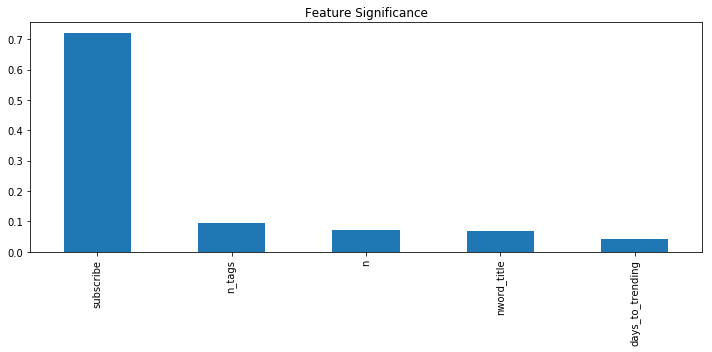

In [26]:
# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(forest.feature_importances_, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(random_state=42)
gbrt.fit(X_train_std, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_valid_std, y_valid)))

훈련 세트 정확도: 0.935
테스트 세트 정확도: 0.914


In [28]:
gbrt = GradientBoostingRegressor(random_state=42, learning_rate=0.3,max_depth=3)
gbrt.fit(X_train_std, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_valid_std, y_valid)))

훈련 세트 정확도: 0.987
테스트 세트 정확도: 0.974


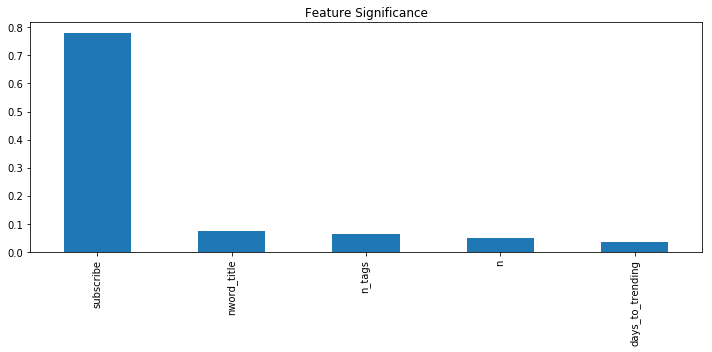

In [29]:
gbrt = GradientBoostingRegressor(random_state=42, learning_rate=0.3,max_depth=3) #best model 선택
gbrt.fit(X_train_std, y_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(gbrt.feature_importances_, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

Variable: subscribe            Importance: 0.72
Variable: n_tags               Importance: 0.1
Variable: n                    Importance: 0.07
Variable: nword_title          Importance: 0.07
Variable: days_to_trending     Importance: 0.04


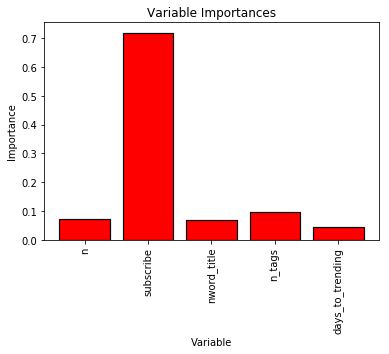

In [30]:
# Get numerical feature importances

feature_list = list(X_train.columns)
importances = list(forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

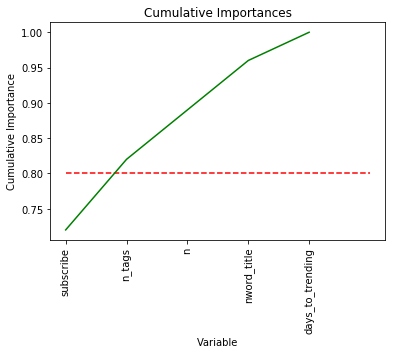

In [31]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 80% of importance retained
plt.hlines(y = 0.80, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

주요변수 3개가 model 75%를 설명하는 것을 볼수있다
주요 변수를 바탕으로 views 에 끼치는 영향을 본다

In [32]:
df.columns

Index(['channel_title', 'n', 'video_id', 'trending_date', 'title', 'tags',
       'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'channel_id', 'subscribe', 'len_title', 'nword_title',
       'n_tags', 'category', 'publish_date', 'days_to_trending', 'category_E'],
      dtype='object')

In [33]:
df_p=df[['subscribe','n_tags','days_to_trending','views']]
df_p.head()

,subscribe,n_tags,days_to_trending,views
0,10460409,1,1,748374
1,6505413,4,1,2418783
2,5487024,22,2,3191434
3,14395362,27,1,343168
4,21284569,14,2,2095731


In [34]:
df_p.groupby(df_p.views).mean()


,subscribe,n_tags,days_to_trending
views,,,
549,95288.0,11.0,3.0
554,95288.0,11.0,4.0
559,95288.0,11.0,5.0
658,1908.0,1.0,17.0
687,42846.0,10.0,3.0
704,42846.0,10.0,4.0
713,1908.0,1.0,18.0
745,1908.0,1.0,19.0
748,915562.0,31.0,2.0


In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [36]:
# X_train_std, y_train

X = sm.add_constant(X_train_std) # adding a constant
Y= y_train

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     232.7
Date:                Thu, 28 Mar 2019   Prob (F-statistic):          1.38e-187
Time:                        00:57:07   Log-Likelihood:                -26655.
No. Observations:                1630   AIC:                         5.332e+04
Df Residuals:                    1624   BIC:                         5.335e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   8.36e+04     18.471      0.0

In [37]:
X_train.head()

,n,subscribe,nword_title,n_tags,days_to_trending
740,5,133643,17,20,3
34013,73,541061,9,17,6
18379,73,541055,9,14,1
10362,4,292795,5,22,8
28185,23,133041,12,9,3


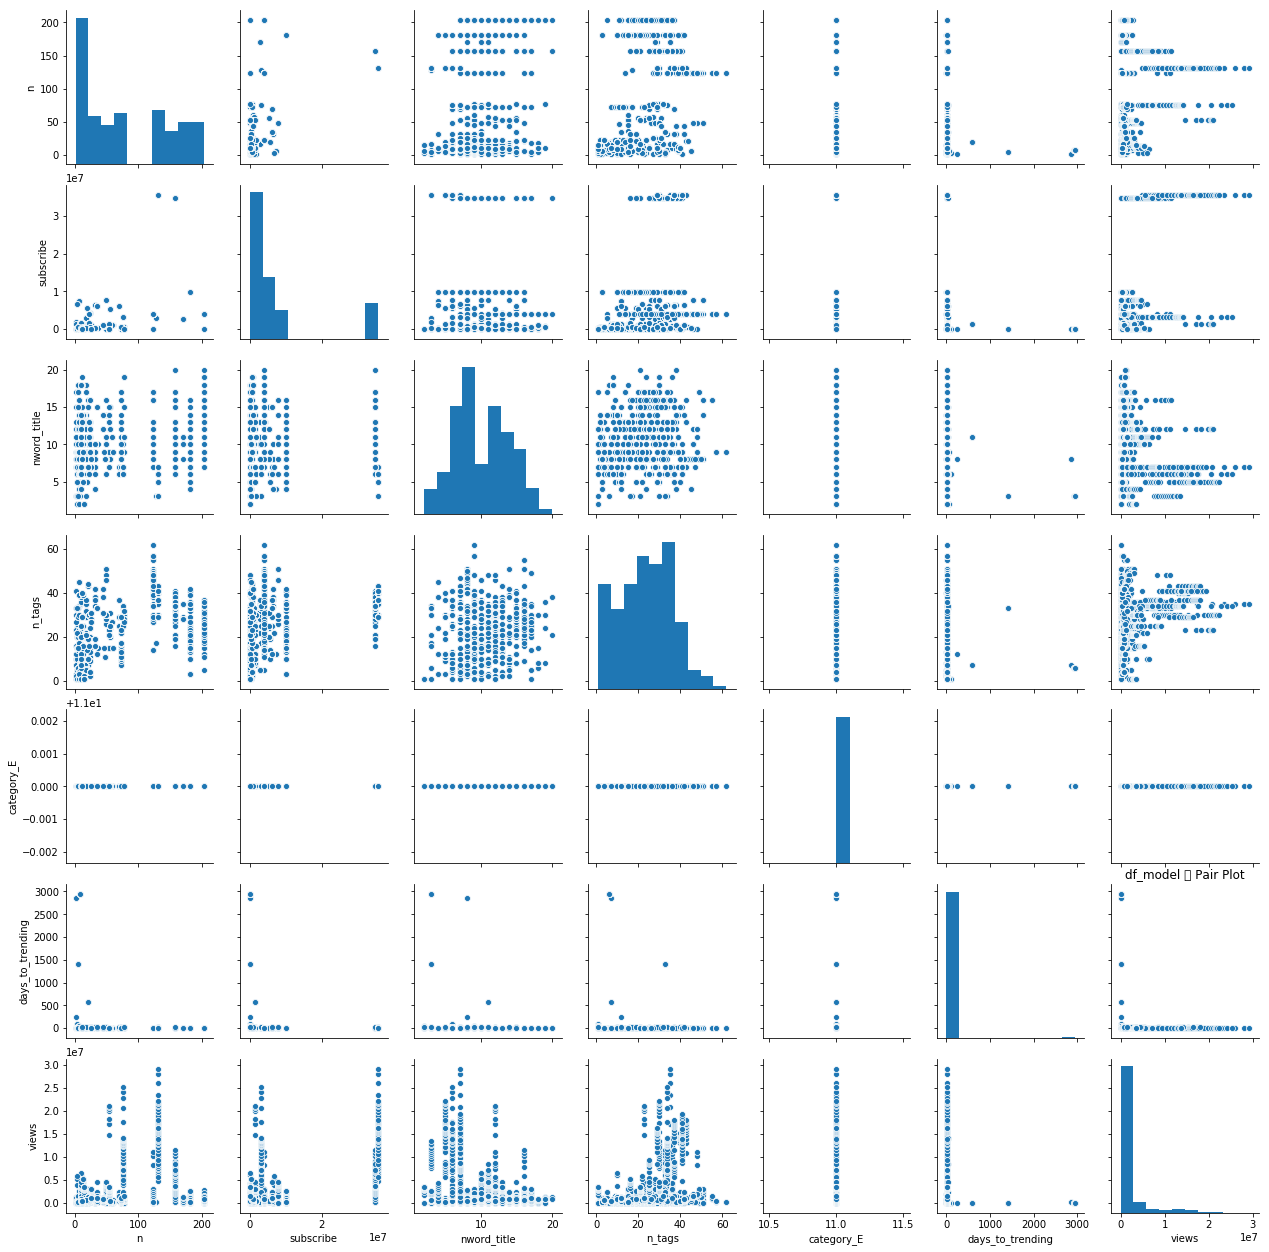

In [38]:
#_=sns.pairplot(df_model)
sns.pairplot(df_model)
plt.title("df_model 의 Pair Plot")
plt.show()

## 데이터 분포를 변환시켜서 다시 분석.

### 데이터 분포 변환
대부분의 모델은 변수가 특정 분포를 따른다는 가정을 기반으로 한다. 예를 들어 선형 모델의 경우, 설명 및 종속변수 모두가 정규분포와 유사할 경우 성능이 높아지는 것으로 알려져 있다. 자주 쓰이는 방법은 Log, Exp, Sqrt 등 함수를 이용해 데이터 분포를 변환하는 것이다. 

밑에 방법 외에도 분포의 특성에 따라 제곱, 자연로그, 지수 등 다양한 함수가 사용될 수 있다. 가이드는 아래와 같다.

left_distribution: X^3
mild_left: X^2
mild_right: sqrt(X)
right: ln(X)
servere right: 1/X

In [39]:
import math
from sklearn import preprocessing

# 특정 변수에만 함수 적용
# df['X_log'] = preprocessing.scale(np.log(df['X']+1)) # 로그
# df['X_sqrt'] = preprocessing.scale(np.sqrt(df['X']+1)) # 제곱근

# # 데이터 프레임 전체에 함수 적용 (단, 숫자형 변수만 있어야 함)
# df_log = df_model.apply(lambda x: np.log(x+1))    

df_model['subscribe_log']= preprocessing.scale(np.log(df_model['subscribe']+1))
df_model['days_to_trending_log']= preprocessing.scale(np.log(df_model['days_to_trending']+1))
df_model['views_log']= preprocessing.scale(np.log(df_model['views']+1))

C:\Users\dojin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\dojin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\dojin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [40]:
df_model.drop('views',axis=1,inplace=True)
df_model.drop('subscribe',axis=1,inplace=True)
df_model.drop('days_to_trending',axis=1,inplace=True)


C:\Users\dojin\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


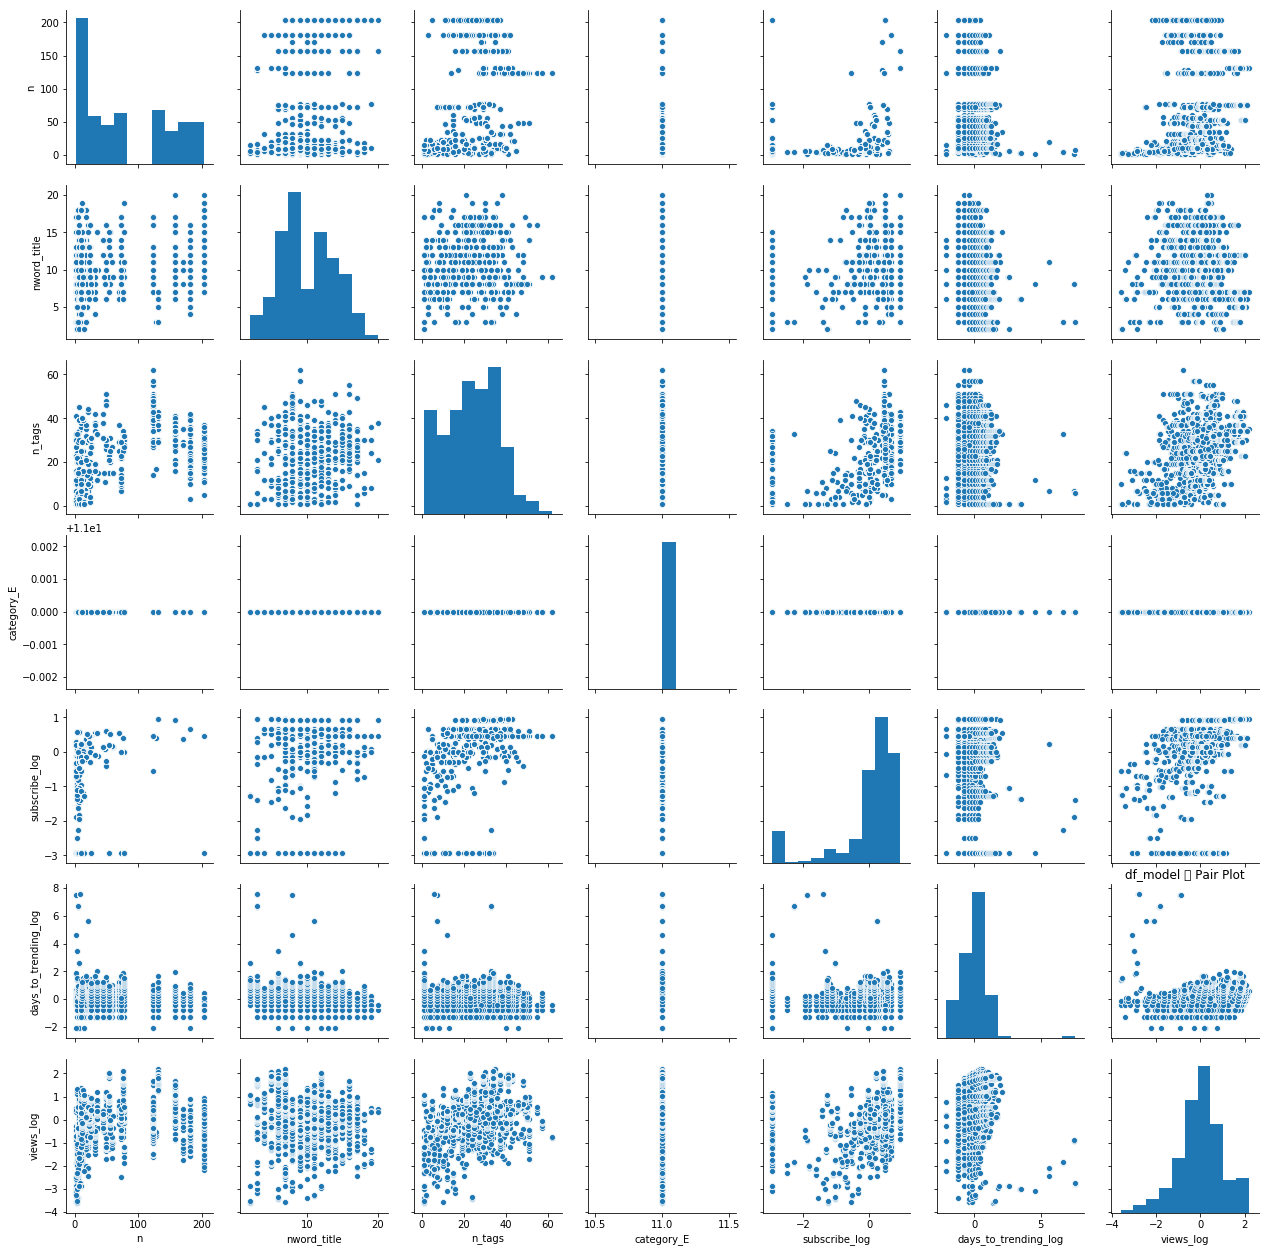

In [41]:
#_=sns.pairplot(df_model)
# views, subscribe 변수를 로그전환 하였다
sns.pairplot(df_model)
plt.title("df_model 의 Pair Plot")
plt.show()

### 데이터 단위 변환
데이터의 스케일(측정단위)이 다를 경우 특히 거리를 기반으로 분류하는 모델(KNN 등)에 부정적인 영향을 미치므로, 스케일링을 통해 단위를 일정하게 맞추는 작업을 진행해야 한다. 아래 방식이 주로 스케일링을 위해 쓰이는 방법이다. 대부분의 통계 분석 방법이 정규성 가정을 기반으로 하므로 완벽하지 않더라도 최대한 정규분포로 변환하는 노력이 필요하다.

Scaling: 평균이 0, 분산이 1인 분포로 변환
MinMax Scaling: 특정 범위 (예, 0~1)로 모든 데이터를 변환
Box-Cox: 여러 k 값중 가장 작은 SSE 선택
Robust_scale: median, interquartile range 사용(outlier 영향 최소화)

In [42]:
# from scipy.stats import boxcox

# # 변수별 scaling 적용
# df['X_scale'] = preprocessing.scale(df['X']) 
# df['X_minmax_scale'] = preprocessing.MinMaxScaler(df['X']
# df['X_boxcox'] = preprocessing.scale(boxcox(df['X']+1)[0])
# df['X_robust_scale'] = preprocessing.robust_scale(df['X'])

# # 데이터 프레임 전체에 scaling 적용
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

# # StandardScaler
# for c in df:
#     df_sc[c] = StandardScaler().fit_transform(df[c].reshape(-1,1)).round(4)

# # MinMaxScaler
# for c in df:
#     df_minmax[c] = MinMaxScaler().fit_transform(df[c].reshape(-1,1).round(4))


In [43]:
Label = df_model['views_log']
features = df_model[['n', 'subscribe_log','nword_title','n_tags','days_to_trending_log']]

In [44]:
# Training and Testing Sets
from sklearn.model_selection import train_test_split

# 데이터를 훈련+검증 세트 그리고 테스트 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    features, Label, random_state=0)

print("train 세트의 크기: {}   validate 세트의 크기: {}  "
      " \n".format(X_train.shape[0], X_valid.shape[0] ))


# X_train, y_train  //  X_valid, y_valid  //  

train 세트의 크기: 1630   validate 세트의 크기: 544   



In [45]:
### 데이터 전처리 - 데이터 표준화 작업 (scaling)
from sklearn.preprocessing import RobustScaler

sc = RobustScaler()
transformer = sc.fit(X_train)
transformer


RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [46]:
#위에서 training set으로 fit 시킨 평균,분산 값을 이용하여 각 세트의 독립변수(X)들을 변환시킨다. 
X_train_std=transformer.transform(X_train)
X_valid_std=transformer.transform(X_valid)



In [47]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train_std, y_train)

C:\Users\dojin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [48]:
print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train_std, y_train)))
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_valid_std, y_valid)))

훈련 세트 정확도: 0.987
테스트 세트 정확도: 0.886


Variable: subscribe_log        Importance: 0.41
Variable: n                    Importance: 0.25
Variable: n_tags               Importance: 0.15
Variable: nword_title          Importance: 0.1
Variable: days_to_trending_log Importance: 0.09


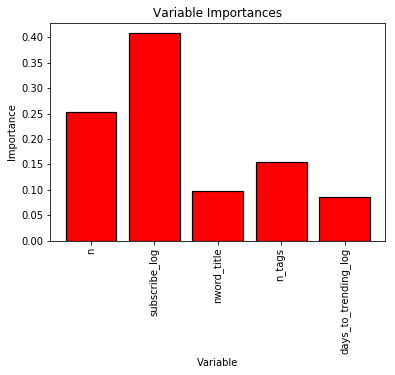

In [49]:
# Get numerical feature importances

feature_list = list(X_train.columns)
importances = list(forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

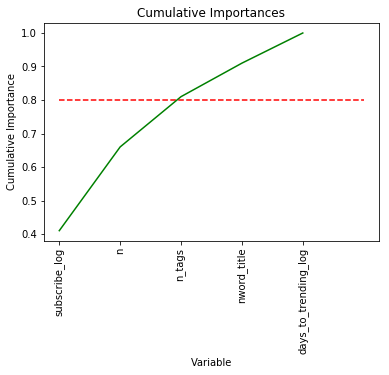

In [50]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 80% of importance retained
plt.hlines(y = 0.80, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

주요변수 3개가 model 70%를 설명하는 것을 볼수있다 주요 변수를 바탕으로 views 에 끼치는 영향을 본다

In [51]:
df_p=df[['subscribe','n','days_to_trending','views']]
df_p.head()

,subscribe,n,days_to_trending,views
0,10460409,95,1,748374
1,6505413,24,1,2418783
2,5487024,74,2,3191434
3,14395362,147,1,343168
4,21284569,89,2,2095731


In [52]:
df_p.groupby(df_p.views).mean()

,subscribe,n,days_to_trending
views,,,
549,95288.0,6.0,3.0
554,95288.0,6.0,4.0
559,95288.0,6.0,5.0
658,1908.0,3.0,17.0
687,42846.0,2.0,3.0
704,42846.0,2.0,4.0
713,1908.0,3.0,18.0
745,1908.0,3.0,19.0
748,915562.0,39.0,2.0


In [53]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# X_train_std, y_train

X = sm.add_constant(X_train_std) # adding a constant
Y= y_train

model = sm.OLS(Y, X).fit()

predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              views_log   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     108.2
Date:                Thu, 28 Mar 2019   Prob (F-statistic):           9.06e-99
Time:                        00:57:17   Log-Likelihood:                -2071.8
No. Observations:                1630   AIC:                             4156.
Df Residuals:                    1624   BIC:                             4188.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0595      0.027      2.189      0.0

In [54]:
X_train.head()

,n,subscribe_log,nword_title,n_tags,days_to_trending_log
740,5,-0.306776,17,20,-0.423578
34013,73,0.005420,9,17,0.253656
18379,73,0.005417,9,14,-1.262408
10362,4,-0.131674,5,22,0.557791
28185,23,-0.307784,12,9,-0.423578
